Reading logs from ../logs/V1
Classifying malicious_ransomwarePOC_10min_1.log as malicious, 13383 malicious entries found
Classifying malicious_ransomwarePOC_10min.log as malicious, 14477 malicious entries found
System calls amount: 103698
Malicious system calls amount: 27860


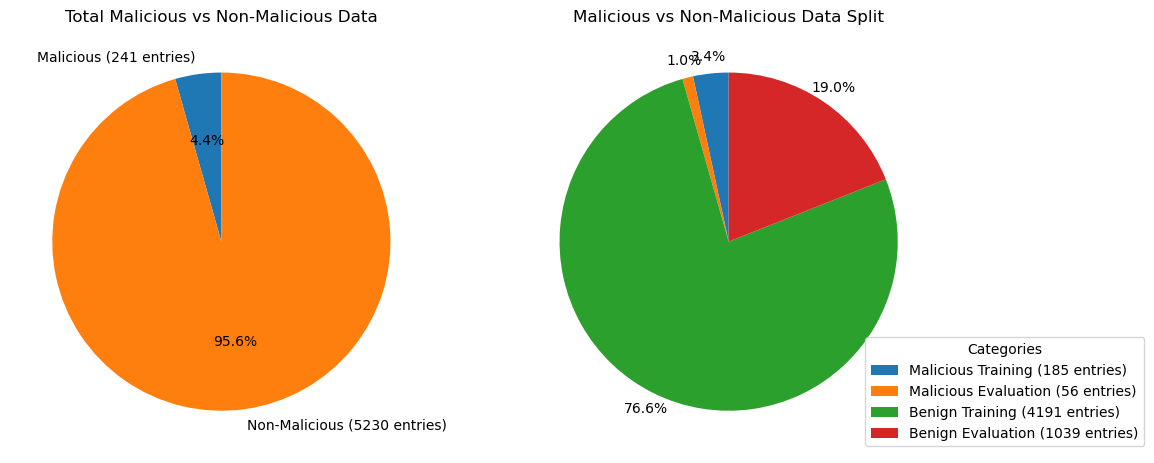

In [92]:
# V1 data overview
from log_reader import read_all_logs
from preprocessors.preprocessor import Preprocessor
import matplotlib.pyplot as plt
from train_models import train_test_split_df

df = read_all_logs(version=1)
print(f"System calls amount: {df.shape[0]}")
print(f"Malicious system calls amount: {df['malicious'].sum()}")

df = Preprocessor.get(version=1).preprocess(df)

X_train, X_test, y_train, y_test = train_test_split_df(df)

# Count the number of malicious and non-malicious entries
malicious_train_count = y_train.sum()
malicious_test_count = y_test.sum()
malicious_count = malicious_train_count + malicious_test_count
non_malicious_train_count = len(y_train) - malicious_train_count
non_malicious_test_count = len(y_test) - malicious_test_count
non_malicious_count = non_malicious_train_count + non_malicious_test_count

# Create labels and sizes for the pie chart
labels = [f'Malicious ({malicious_count} entries)', f'Non-Malicious ({non_malicious_count} entries)']
sizes = [malicious_count, non_malicious_count]

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Create the pie chart
axs[0].pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)

# Add a title
axs[0].set_title('Total Malicious vs Non-Malicious Data')

labels = [f'Malicious Training ({malicious_train_count} entries)', f'Malicious Evaluation ({malicious_test_count} entries)', f'Benign Training ({non_malicious_train_count} entries)', f'Benign Evaluation ({non_malicious_test_count} entries)']
sizes = [malicious_train_count, malicious_test_count, non_malicious_train_count, non_malicious_test_count]

wedges, texts, autotexts = axs[1].pie(sizes, autopct='%1.1f%%', startangle=90, pctdistance=1.1)

axs[1].legend(wedges, labels, title="Categories", loc="lower right", bbox_to_anchor=(1, 0, 0.5, 1))
axs[1].set_title('Malicious vs Non-Malicious Data Split')


# Display the chart
plt.show()


Best model: 
Model                      RF
Model_Type     Classification
Scaler        TfidfVectorizer
Min Ngram                   5
Max Ngram                   5
Score                     1.0
Duration            19.833601
F1                        1.0
Recall                    1.0
Precision                 1.0
Name: 0, dtype: object


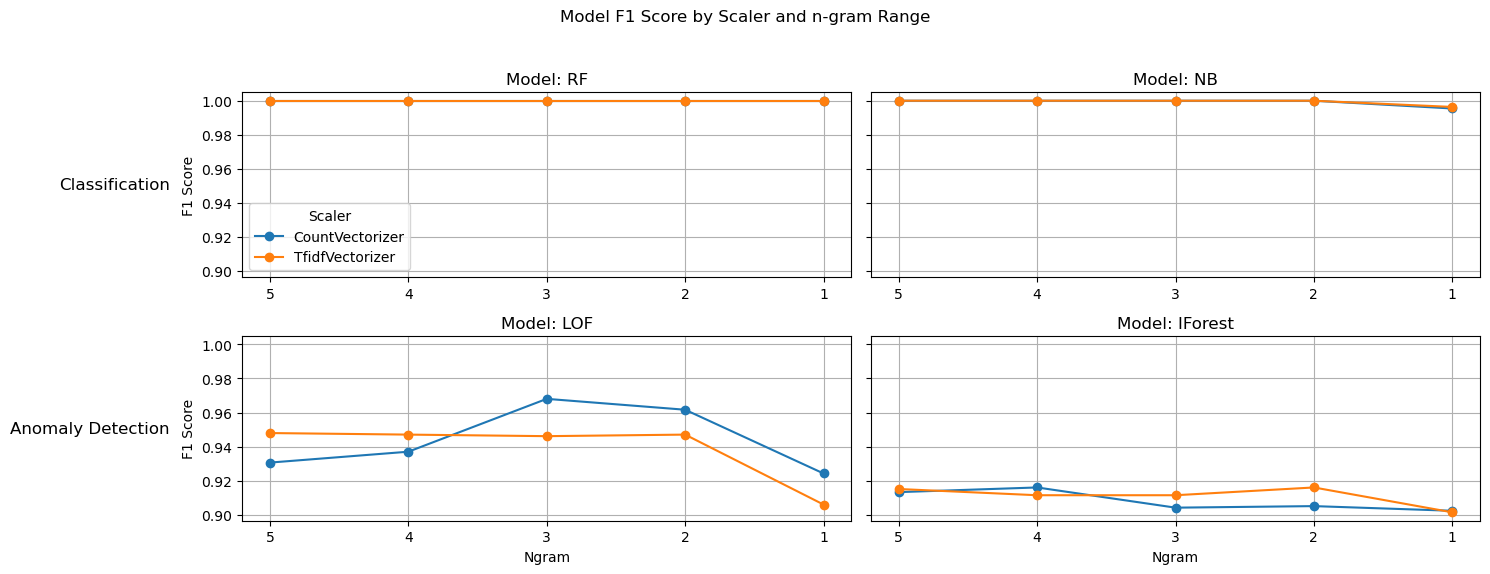

In [93]:
# V1 F1 models evaluation results
from train_models import load_scores
import matplotlib.pyplot as plt
import os

# Load model scores
models_dir = os.path.join(os.getcwd(), 'models/trained')
model_score = load_scores(version=1, output_dir=models_dir)

# Create graph of accuracy per model
print("Best model: ")
print(model_score.iloc[0])

model_score = model_score.sort_values(['Min Ngram', 'Max Ngram'], ascending=[False, True])

# Create a figure with subplots for each model
types = model_score['Model_Type'].unique()
models = model_score['Model'].unique()
cols = int(len(models)/len(types))

models.sort()
fig, axs = plt.subplots(len(types), cols, figsize=(15, 6), sharey=True) 
for i, type in enumerate(types):
    ax_row = axs[i]
    for ax, model in zip(ax_row, model_score[model_score['Model_Type'] == type]['Model'].unique()):
        df_model = model_score[model_score['Model'] == model]
        for label, df_grouped in df_model.groupby('Scaler'):
            ax.plot(df_grouped['Min Ngram'].astype(str), 
                    df_grouped['Score'], label=label, marker='o')
        ax.set_title(f'Model: {model}')
        ax.grid(True)
    # Add row title
    axs[i][0].annotate(type, xy=(0, 0.5), xytext=(-axs[i][0].yaxis.labelpad - 5, 0),
                       xycoords=axs[i][0].yaxis.label, textcoords='offset points',
                       size='large', ha='right', va='center')
    axs[i][0].set_ylabel('F1 Score')
for i in range(cols):
    axs[-1][i].set_xlabel('Ngram')
axs[0][0].legend(title='Scaler')

plt.suptitle('Model F1 Score by Scaler and n-gram Range')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


Best model: 
Model                      RF
Model_Type     Classification
Scaler        TfidfVectorizer
Min Ngram                   5
Max Ngram                   5
Score                     1.0
Duration            19.833601
F1                        1.0
Recall                    1.0
Precision                 1.0
Name: 0, dtype: object


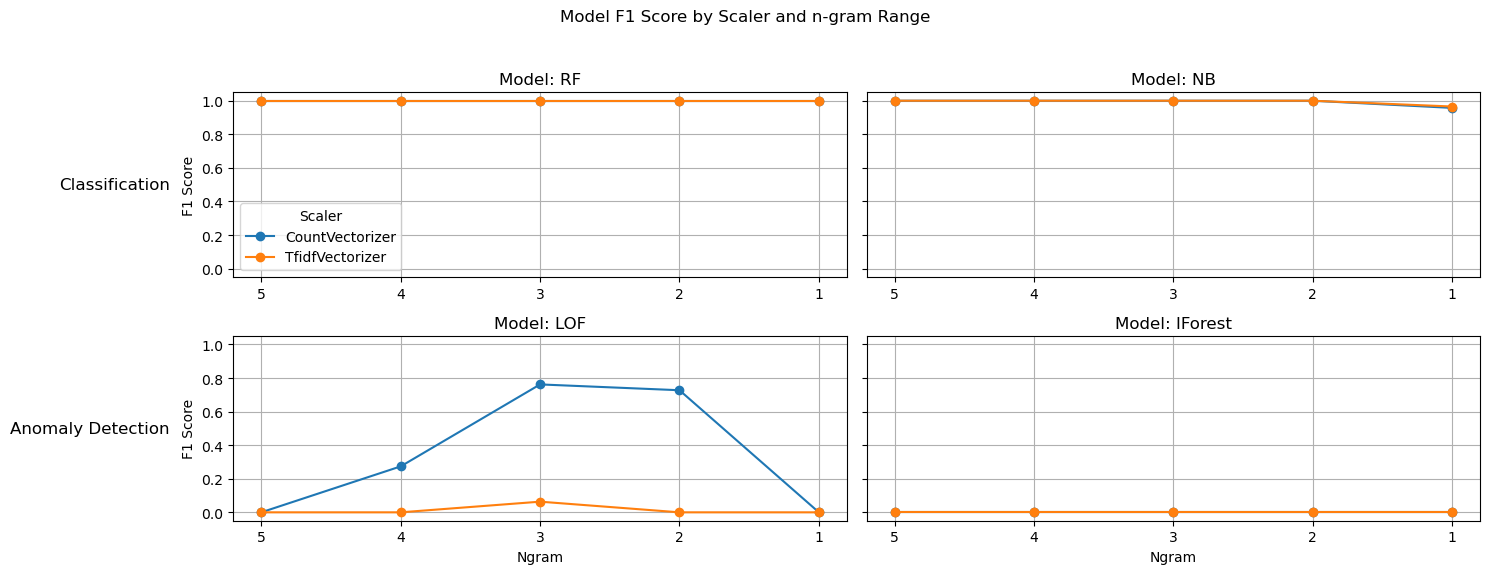

In [94]:
# V1 F1 models evaluation results
from train_models import load_scores
import matplotlib.pyplot as plt
import os

# Load model scores
models_dir = os.path.join(os.getcwd(), 'models/trained')
model_score = load_scores(version=1, output_dir=models_dir)

# Create graph of accuracy per model
print("Best model: ")
print(model_score.iloc[0])

model_score = model_score.sort_values(['Min Ngram', 'Max Ngram'], ascending=[False, True])

# Create a figure with subplots for each model
types = model_score['Model_Type'].unique()
models = model_score['Model'].unique()
cols = int(len(models)/len(types))

models.sort()
fig, axs = plt.subplots(len(types), cols, figsize=(15, 6), sharey=True) 
for i, type in enumerate(types):
    ax_row = axs[i]
    for ax, model in zip(ax_row, model_score[model_score['Model_Type'] == type]['Model'].unique()):
        df_model = model_score[model_score['Model'] == model]
        for label, df_grouped in df_model.groupby('Scaler'):
            ax.plot(df_grouped['Min Ngram'].astype(str), 
                    df_grouped['F1'], label=label, marker='o')
        ax.set_title(f'Model: {model}')
        ax.grid(True)
    # Add row title
    axs[i][0].annotate(type, xy=(0, 0.5), xytext=(-axs[i][0].yaxis.labelpad - 5, 0),
                       xycoords=axs[i][0].yaxis.label, textcoords='offset points',
                       size='large', ha='right', va='center')
    axs[i][0].set_ylabel('F1 Score')
for i in range(cols):
    axs[-1][i].set_xlabel('Ngram')
axs[0][0].legend(title='Scaler')

plt.suptitle('Model F1 Score by Scaler and n-gram Range')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [95]:
from train_models import load_model, train_test_split_df
from log_reader import read_all_logs
from preprocessors.preprocessor import Preprocessor
import matplotlib.pyplot as plt
import os
import pandas as pd

# Load models
ad = load_model('models/trained/v1/v1_LOF_CountVectorizer_3_3.pkl')
classifier = load_model('models/trained/v1/v1_NB_TfidfVectorizer_3_3.pkl')

# Load data
df = read_all_logs(version=1)
preprocessor = Preprocessor.get(version=1)
df = preprocessor.preprocess(df)

X_train, X_test, y_train, y_test = train_test_split_df(df)

# Evaluate models
ad_pred = ad.predict(X_test)
classifier_pred = classifier.predict(X_test)

scores = pd.DataFrame({'Actual': y_test, 'AD': ad_pred, 'Classifier': classifier_pred})
scores['AD_Accuracy'] = scores['AD'] - scores['Actual']
scores['Classifier_Accuracy'] = scores['Classifier'] - scores['Actual']

print(scores['AD_Accuracy'].value_counts())
print(scores['Classifier_Accuracy'].value_counts())


Reading logs from ../logs/V1
Classifying malicious_ransomwarePOC_10min_1.log as malicious, 13383 malicious entries found
Classifying malicious_ransomwarePOC_10min.log as malicious, 14477 malicious entries found
AD_Accuracy
0    1060
1      35
Name: count, dtype: int64
Classifier_Accuracy
0    1095
Name: count, dtype: int64


In [96]:
# V2 training durations
from train_models import load_scores
import matplotlib.pyplot as plt
import os

# Load model scores
models_dir = os.path.join(os.getcwd(), 'models/trained')
model_score = load_scores(version=1, output_dir=models_dir)

model_score = model_score[model_score['Min Ngram'] == 3]

model_score = model_score[['Duration', 'Model']].groupby('Model').mean()
model_score

,Duration
Model,
IForest,0.551323
LOF,3.663124
NB,0.081933
RF,9.305123


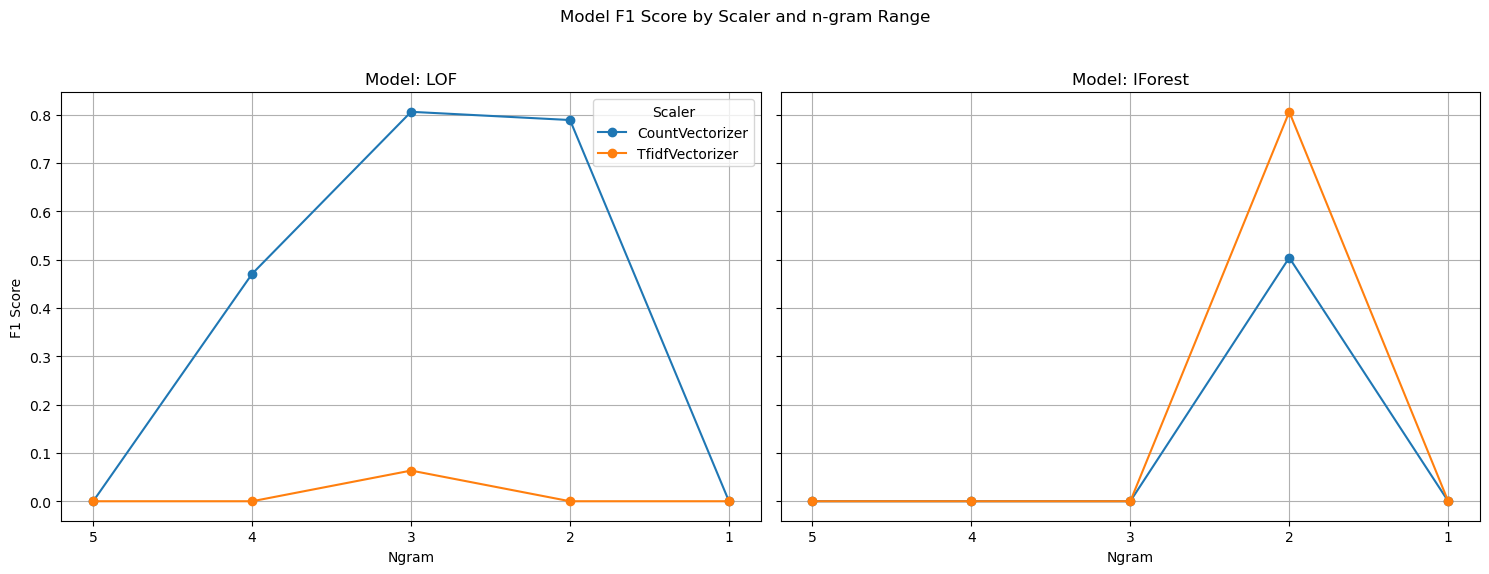

In [97]:
# V1 AD F1 performance with new hyperparameters
from train_models import load_scores_from_dir
import matplotlib.pyplot as plt
import os

# Load model scores
models_dir = os.path.join(os.getcwd(), 'models/trained/v1_new')
model_score = load_scores_from_dir(models_dir)

# only consider AD models
model_score = model_score[model_score['Model_Type'] == 'Anomaly Detection']

model_score = model_score.sort_values(['Min Ngram', 'Max Ngram'], ascending=[False, True])

# Create a figure with subplots for each model
models = model_score['Model'].unique()
cols = len(models)

models.sort()
fig, axs = plt.subplots(1, cols, figsize=(15, 6), sharey=True) 

for ax, model in zip(axs, model_score['Model'].unique()):
    df_model = model_score[model_score['Model'] == model]
    for label, df_grouped in df_model.groupby('Scaler'):
        ax.plot(df_grouped['Min Ngram'].astype(str), 
                df_grouped['F1'], label=label, marker='o')
    ax.set_title(f'Model: {model}')
    ax.grid(True)
axs[0].set_ylabel('F1 Score')
for i in range(cols):
    axs[i].set_xlabel('Ngram')
axs[0].legend(title='Scaler')

plt.suptitle('Model F1 Score by Scaler and n-gram Range')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [99]:
# V1 best model performances with new hyperparameters
from train_models import load_scores_from_dir
import matplotlib.pyplot as plt
import os

# Load model scores
models_dir = os.path.join(os.getcwd(), 'models/trained/v1_new')
model_score = load_scores_from_dir(models_dir)

# show best performing model per model
model_score = model_score.groupby('Model').apply(lambda x: x.nlargest(1, 'F1')).reset_index(drop=True)
model_score.sort_values('F1', ascending=False, inplace=True)
model_score

/var/folders/qm/bgf8w3t57rs0n48ykj9024nr0000gn/T/ipykernel_58896/315368899.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  model_score = model_score.groupby('Model').apply(lambda x: x.nlargest(1, 'F1')).reset_index(drop=True)


,Model,Model_Type,Scaler,Min Ngram,Max Ngram,Score,Duration,F1,Recall,Precision
2,NB,Classification,CountVectorizer,5,5,1.000000,0.092075,1.000000,1.000000,1.0
3,RF,Classification,TfidfVectorizer,5,5,1.000000,20.214922,1.000000,1.000000,1.0
0,IForest,Anomaly Detection,TfidfVectorizer,2,2,0.975342,0.702931,0.805755,0.674699,1.0
1,LOF,Anomaly Detection,CountVectorizer,3,3,0.975342,2.460499,0.805755,0.674699,1.0
